# 4. Active journals using OJS by country and World Bank income group

### Notebook objectives:
1. [Determine the number of active OJS journals by country.](#country)
2. [Group journals by country income level using World Bank GNI data*.](#wb)
<br>
*<a href='https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups'>GNI data</a> are updated as of FY22 but reflect 2020 data

Import packages and read the cleaned beacon dataset into pandas:

In [1]:
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import time
import os
import re

In [2]:
beaconActive = pd.read_csv(os.path.join('data', 'beacon_active.csv'))

Rename the beaconActive DataFrame's 'country_consolidated' variable as 'tld' (top-level domain):

In [3]:
beaconActive.rename(columns={'country_consolidated':'tld'}, inplace=True)

### Preprocess the World Bank country and lending group dataset:

In [4]:
wbGroups = pd.read_excel(os.path.join('data','wb_tlds.xlsx'))

In [5]:
#Select only the country, income_group, and tld variables, and rename them accordingly:
wbGroups = wbGroups[['Economy',
                     'Income group',
                     'Domain']]
wbGroups.rename(columns={'Economy':'country','Income group':'income_group','Domain':'tld'}, inplace=True)

In [6]:
wbGroups.isnull().sum()

country         0
income_group    0
tld             1
dtype: int64

In [7]:
#There is one missing 'tld' value
wbGroups[wbGroups['tld'].isnull()]

,country,income_group,tld
141,Namibia,Upper middle income,NaN


In [8]:
#Namibia is missing! The top-level domain 'NA' read into pandas as NaN
#Change NaN to NA in the 'tld' column for Nigerian contexts
wbGroups['tld'] = np.where(wbGroups['tld'].isnull(), 'NA', wbGroups['tld'])
beaconActive['tld'] = np.where(beaconActive['oai_url'].str.contains('.na/'), 'NA', beaconActive['tld'])

Filter the World Bank income group dataset to include only those countries that match beaconActive:

In [9]:
wbGroups = wbGroups[wbGroups['tld'].isin(beaconActive['tld'])].reset_index()
wbGroups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         139 non-null    int64 
 1   country       139 non-null    object
 2   income_group  139 non-null    object
 3   tld           139 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.5+ KB


In [10]:
#Check for duplicates in the 'tld' column 
wbGroups[wbGroups['tld'].duplicated()]

,index,country,income_group,tld
134,216,Kosovo,Upper middle income,AL


In [11]:
#Kosovo shares a top-level domain with Albania. But both Kosovo and Albania belong to the same income_group
#Merging on 'tld', so delete Kosovo for now
wbGroups.drop(index=134, inplace=True)

In [12]:
#Drop the index column
wbGroups.drop('index', axis=1, inplace=True)
for group in wbGroups['income_group'].unique():
    print(group)

Low income
Lower middle income
Upper middle income
High income
Unclassified


Change Venezuela's income classification from 'Unclassified' (2021) to its previous classification (2020):

In [13]:
wbGroups['income_group'] = np.where(wbGroups['income_group'].str.contains('Unclassified'),
                                    'Upper middle income',
                                    wbGroups['income_group'])

#### Merge the Beacon and World Bank datasets by Top-Level Domain

In [14]:
incomeGroups = beaconActive.merge(wbGroups, how='inner', on='tld')
print(incomeGroups.shape)

(25651, 40)


In [15]:
incomeGroups.isnull().sum()

Unnamed: 0                   0
oai_url                      0
application                  0
version                     34
admin_email                658
earliest_datestamp          99
repository_name           4139
set_spec                     0
context_name                 0
stats_id                     0
total_record_count           0
issn                      2819
country_marc              2856
country_issn              2931
country_tld               5276
country_ip                 191
tld                          0
last_completed_update       22
first_beacon                 0
last_beacon                  0
last_oai_response           99
unresponsive_endpoint        0
unresponsive_context         0
record_count_2010            0
record_count_2011            0
record_count_2012            0
record_count_2013            0
record_count_2014            0
record_count_2015            0
record_count_2016            0
record_count_2017            0
record_count_2018            0
record_c

## Distribution of active OJS journals by country:<a id='country'></a>

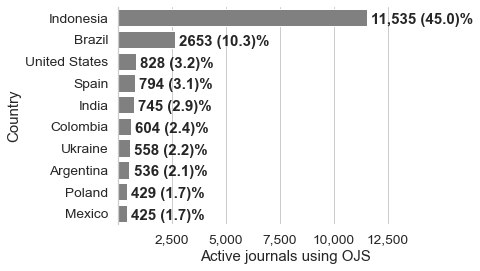

In [17]:
#Plot the distribution of OJS journals by World Bank income group
sns.set(font_scale=1.25)
sns.set_style('whitegrid')

fig, ax = plt.subplots()

inc = sns.barplot(y=incomeGroups['country'].value_counts().index[:10],
                  x=incomeGroups['country'].value_counts().iloc[:10],
                  data=incomeGroups,
                  color='grey')

ax.set(xlim=(0, 15500),
       xlabel = 'Active journals using OJS',
       ylabel = 'Country')#,
       #title='''The distribution of active journals using OJS across World Bank country groups \n
       #based on gross national income (GNI) per capita ($\it{n}$ = 25,651)''')
sns.despine(bottom=True)

plt.xticks([2500, 5000, 7500, 10000, 12500],
                         ['2,500', '5,000', '7,500', '10,000', '12,500'])

for p in inc.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.125
    value = '{:,}'.format(p.get_width())
    percent = round(((p.get_width() / 25651) * 100), 1)
    if len(str(int(p.get_width()))) == 5:
        value = str(int(p.get_width()))[:2] + ',' + str(int(p.get_width()))[2:] + f' ({str(percent)})%'
    elif len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + f' ({str(percent)})%'
        value = str(int(p.get_width())) + f' ({str(percent)})%'
    else:
        value = str(int(p.get_width())) + f' ({str(percent)})%' 
    inc.text(_x + 200, _y, value, ha='left', weight='bold')

inc.figure.savefig(os.path.join('vis', 'OJScountries.png'), bbox_inches='tight')

## The distribution of active journals using OJS across World Bank country groups based on gross national income (GNI) per capita ($\it{n}$ = 25,651) <a id='wb'></a>

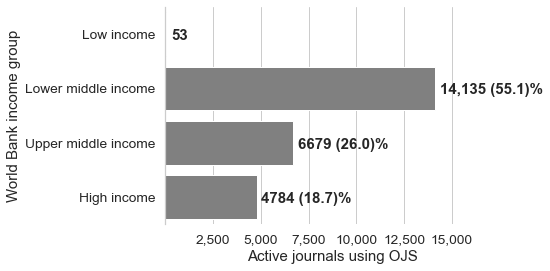

In [18]:
#Plot the distribution of OJS journals by World Bank income group

fig, ax = plt.subplots()

inc = sns.countplot(y='income_group', 
                    order=['Low income',
                           'Lower middle income',
                           'Upper middle income',
                           'High income'],
                    data=incomeGroups,
                    color='grey')

ax.set(xlim=(0, 17500),
       xlabel = 'Active journals using OJS',
       ylabel = 'World Bank income group')#,
       #title='''The distribution of active journals using OJS across World Bank country groups \n
       #based on gross national income (GNI) per capita ($\it{n}$ = 25,651)''')
sns.despine(bottom=True)

plt.xticks([2500, 5000, 7500, 10000, 12500, 15000],
                         ['2,500', '5,000', '7,500', '10,000', '12,500', '15,000'])

for p in inc.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.3
    value = '{:,}'.format(p.get_width())
    percent = round(((p.get_width() / 25651) * 100), 1)
    if len(str(int(p.get_width()))) == 5:
        value = str(int(p.get_width()))[:2] + ',' + str(int(p.get_width()))[2:] + f' ({str(percent)})%'
    elif len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + f' ({str(percent)})%'
        value = str(int(p.get_width())) + f' ({str(percent)})%'
    inc.text(_x + 250, _y, value, ha='left', weight='bold')

inc.figure.savefig(os.path.join('vis', 'OJSincome_groups.png'), bbox_inches='tight')